In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [2]:
# Loading data. This function loads grayscale chest X-ray images, resizes them to 
# 150x150 pixels, labels them as either "PNEUMONIA" or "NORMAL", and returns them as a dataset for training a CNN.
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

In [3]:
# Load training data

train = get_training_data(r'C:\Users\vladp\OneDrive\Desktop\Y3\DataScience\assignment2\Datascience2025_A2\data\chest_xray\train')
test = get_training_data(r'C:\Users\vladp\OneDrive\Desktop\Y3\DataScience\assignment2\Datascience2025_A2\data\chest_xray\test')
val = get_training_data(r'C:\Users\vladp\OneDrive\Desktop\Y3\DataScience\assignment2\Datascience2025_A2\data\chest_xray\val')

<Axes: ylabel='count'>

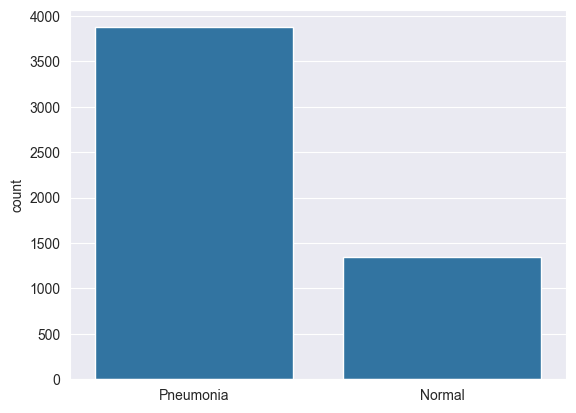

In [4]:
# Compare amounts of data

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'NORMAL')

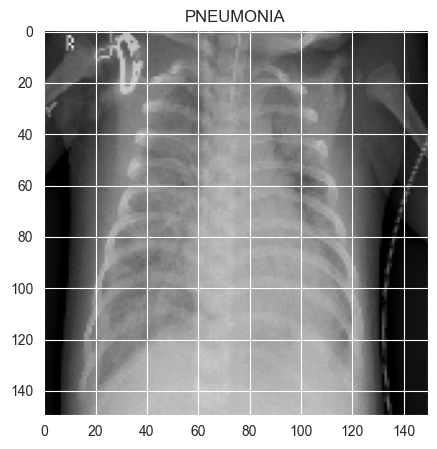

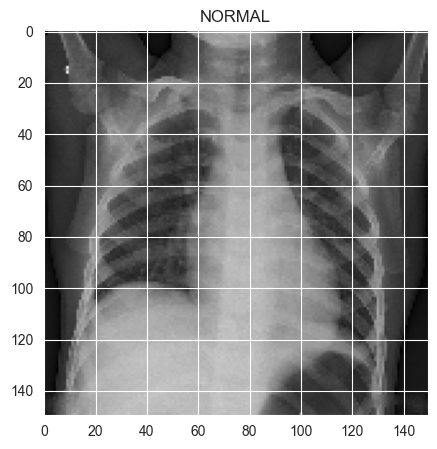

In [5]:
# Show data example.

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
# Data pre-processing. Splitting inital training arrays into features and labels.

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalizing data 
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [7]:
# Prevent overfitting and handling the imbalance in dataset with data augmentation (by rotating, shofting and flipping images randomly)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [8]:
# Builds CNN architecture for binary image classification

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1))) # recognize patterns
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same')) # downsample the image
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')) # recognize patterns
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same')) # downsample the image
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')) # recognize patterns
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same')) # downsample the image
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')) # recognize patterns
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same')) # downsample the image
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')) # recognize patterns
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same')) # downsample the image
model.add(Flatten()) # turns the 2D feature maps into a 1D vector
model.add(Dense(units = 128 , activation = 'relu')) # standard neural network layers.
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid')) # standard neural network layers.
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.summary()

c:\Users\vladp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Monitors val_accuracy during training
# If validation accuracy doesn’t improve after 2 epochs, it reduces the learning rate by a factor of 0.3. 
# It will never reduce the learning rate below 0.000001

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [10]:
# Model training with data augmentation

history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

c:\Users\vladp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.7971 - loss: 0.9955 - val_accuracy: 0.5000 - val_loss: 19.4180 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8904 - loss: 0.2789 - val_accuracy: 0.5000 - val_loss: 56.4819 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9231 - loss: 0.2150
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9231 - loss: 0.2150 - val_accuracy: 0.5000 - val_loss: 30.2479 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9431 - loss: 0.1581 - val_accuracy: 0.5000 - val_loss: 29.3086 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9488 - loss: 0.1351 - val_accuracy: 0.7500 - val_loss: 0.3561 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.9533 -

In [11]:
# Display results

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8958 - loss: 0.3155
Loss of the model is -  0.28270047903060913
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8958 - loss: 0.3155
Accuracy of the model is -  89.42307829856873 %


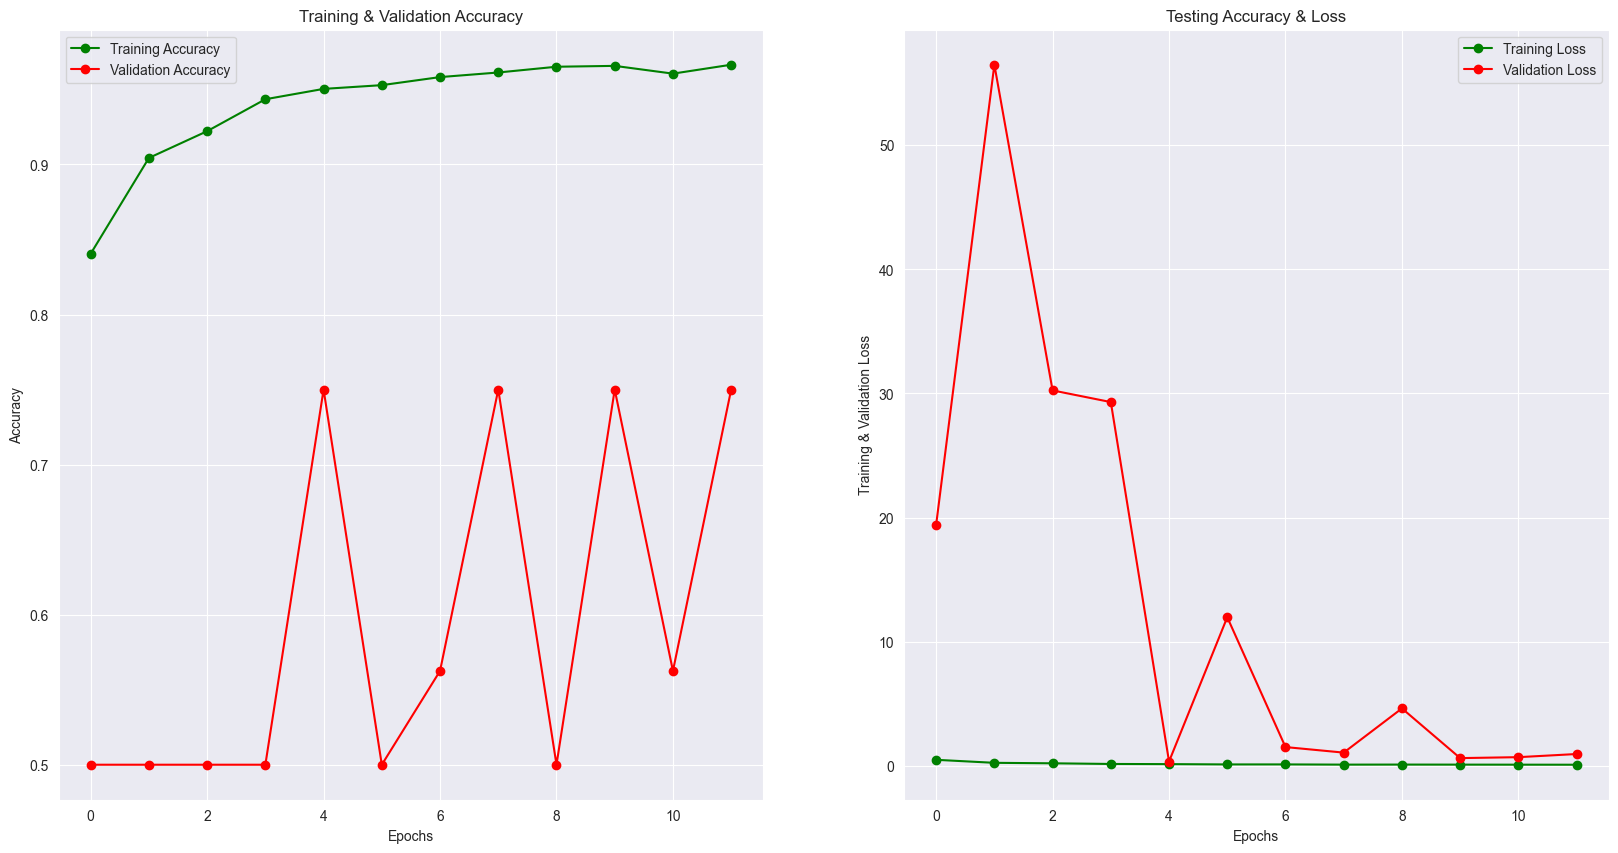

In [12]:
# Analyzing results post training

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# Makes predications on the test images trained by CNN model (either 0 or 1)

predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype("int32")
predicted_classes[:15]

# Compares true labels vs. predicted labels using calculations
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.88      0.91       390
   Normal (Class 1)       0.83      0.91      0.87       234

           accuracy                           0.89       624
          macro avg       0.88      0.90      0.89       624
       weighted avg       0.90      0.89      0.90       624



In [ ]:
# Provides confusion matrix

cm = confusion_matrix(y_test, predicted_classes)
cm


array([[345,  45],
       [ 21, 213]])

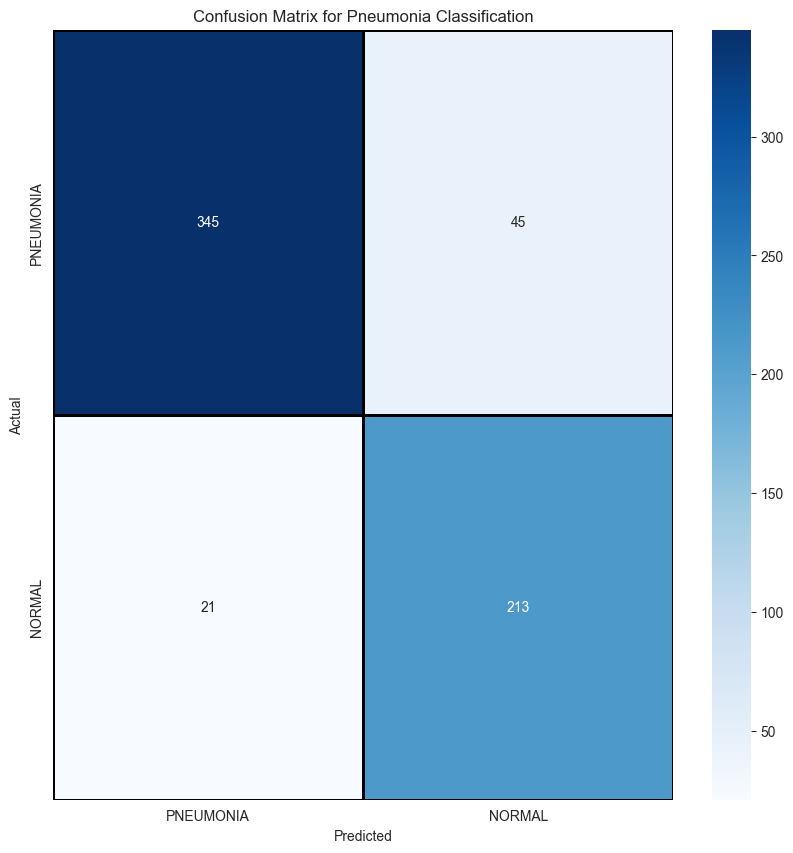

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

# Plots confusion matrix. Visualizes TP/ FP/ TN/ FN.

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1,
         annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Pneumonia Classification")
plt.show()


In [ ]:
# Finds correct and incorrect predictions

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
# Plot correct predictions

i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

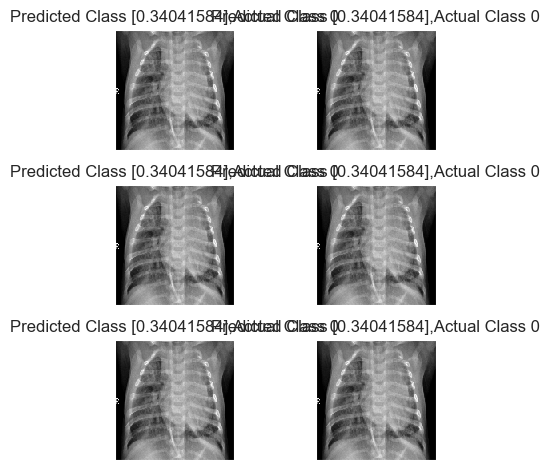

In [ ]:
# Plot incorrect predictions

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1